### Data lake tests after downloading files from Udacity S3 Storage

This is taken forward to make etl.py

In [1]:
import configparser
import os
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, FloatType, TimestampType, LongType, DoubleType

import datetime #Required for ts conversion
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second

from pyspark.sql import Window
from pyspark.sql.functions import asc, desc
from pyspark.sql.functions import sum as Fsum

Make sure that your AWS credentials are loaded as env vars

In [3]:
config = configparser.ConfigParser()

#Normally this file should be in ~/.aws/credentials
config.read_file(open('aws/credentials.cfg'))

os.environ["AWS_ACCESS_KEY_ID"]= config['AWS']['AWS_ACCESS_KEY_ID']
os.environ["AWS_SECRET_ACCESS_KEY"]= config['AWS']['AWS_SECRET_ACCESS_KEY']

### Run S3Download.py to download data from S3

Create spark session with hadoop-aws package

In [4]:
spark = SparkSession \
    .builder \
    .appName("DataLake - Local") \
    .getOrCreate()

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '39049'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '2b56746a4133'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.app.id', 'local-1572799424875'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'DataLake - Local'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
spark

## Gather

In [33]:
%%time
path = "./log_data/*/*/*.json"
path = "./merged_log_data.json"

log_schema = StructType([
    StructField("artist", StringType()),
    StructField("auth", StringType()),
    StructField("firstName", StringType()),
    StructField("gender", StringType()),
    StructField("itemInSession", LongType()),
    StructField("lastName", StringType()),
    StructField("length", DoubleType()),
    StructField("level", StringType()),
    StructField("location", StringType()),
    StructField("method", StringType()),
    StructField("page", StringType()),
    StructField("registration", DoubleType()),
    StructField("sessionId", LongType()),
    StructField("song", StringType()),
    StructField("status", StringType()),
    StructField("ts", StringType()),
    StructField("userAgent", StringType()),
    StructField("userId", StringType())
])

log_df = spark.read.json(path, 
          schema=log_schema)

#log_df = spark.read.json(path)

CPU times: user 0 ns, sys: 2.43 ms, total: 2.43 ms
Wall time: 180 ms


In [34]:
%%time
path = "./song_data/*/*/*/*.json"
path = "./merged_song_data.json"
#path = "data/song-data/song_data/A/A/A/TRAAAAW128F429D538.json"
song_schema = StructType([
	StructField("num_songs", IntegerType()),
    StructField("artist_id", StringType()),
    StructField("artist_latitude", FloatType()),
    StructField("artist_longitude", FloatType()),
    StructField("artist_location", StringType()),
    StructField("artist_name", StringType()),
    StructField("song_id", StringType()),
    StructField("title", StringType()),
    StructField("duration", FloatType()),
    StructField("year", IntegerType())
])

song_df = spark.read.json(path, 
          schema=song_schema)
#song_df = spark.read.schema(song_schema).json(path)

CPU times: user 2.45 ms, sys: 544 µs, total: 3 ms
Wall time: 191 ms


## Assess

In [35]:
log_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [36]:
%%time
log_df.count()

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 906 ms


8056

In [37]:
log_df.show(2)

+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|          song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+--------------+------+-------------+--------------------+------+
|          null|Logged In|    Adler|     M|            0| Barrera|     null| free|New York-Newark-J...|   GET|    Home|1.540835983796E12|      248|          null|   200|1541470364796|"Mozilla/5.0 (Mac...|   100|
|Gustavo Cerati|Logged In|    Adler|     M|            1| Barrera|249.44281| free|New York-Newark-J...|   PUT|NextSong|1.540835983796E12|      248|Uno E

In [38]:
# Checking auth column (Logged Out, Logged In)
log_df.select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Logged In|
+----------+



In [39]:
# Checking gender column ( replace null with blank)
log_df.groupby(log_df.gender).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F| 5482|
|  null|  286|
|     M| 2288|
+------+-----+



In [40]:
# iteminsession
log_df.select("iteminsession").dropDuplicates().show()

+-------------+
|iteminsession|
+-------------+
|           26|
|           29|
|           65|
|           19|
|           54|
|            0|
|          112|
|          113|
|           22|
|            7|
|           77|
|           34|
|          126|
|           50|
|           94|
|          110|
|           57|
|           32|
|           43|
|           84|
+-------------+
only showing top 20 rows



In [41]:
log_df.select("length").dropDuplicates().show()

+---------+
|   length|
+---------+
| 325.0673|
|231.94077|
|347.81995|
|137.84771|
|241.94567|
|213.75955|
|375.03955|
|169.35138|
| 64.67873|
|282.04363|
|438.67383|
|227.83955|
|317.30893|
|216.47628|
|262.79138|
|280.34567|
| 229.0673|
|138.05669|
|175.22893|
|221.98812|
+---------+
only showing top 20 rows



In [42]:
log_df.select("level").dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [43]:
log_df.select("page").dropDuplicates().show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|            Home|
|       Downgrade|
|          Logout|
|   Save Settings|
|           About|
|        Settings|
|           Login|
|        NextSong|
|            Help|
|         Upgrade|
|           Error|
|  Submit Upgrade|
+----------------+



In [44]:
log_df.select("registration").dropDuplicates().show()

+-----------------+
|     registration|
+-----------------+
|1.540472624796E12|
|1.540810448796E12|
|1.541016707796E12|
|1.540823606796E12|
|1.541064343796E12|
|1.540130971796E12|
|1.540676534796E12|
|1.540992766796E12|
|1.540644861796E12|
|1.540907087796E12|
|1.541020249796E12|
|1.540991795796E12|
|1.541003367796E12|
|1.541033612796E12|
|1.541091973796E12|
|1.540306145796E12|
|1.540492941796E12|
|             null|
|1.540970748796E12|
|1.540856629796E12|
+-----------------+
only showing top 20 rows



In [45]:
log_df.select("sessionId").dropDuplicates().show()

+---------+
|sessionId|
+---------+
|      964|
|      474|
|      191|
|      558|
|      418|
|      541|
|     1010|
|      293|
|      222|
|      730|
|      270|
|      938|
|      278|
|      442|
|      720|
|      705|
|      243|
|      296|
|       54|
|      926|
+---------+
only showing top 20 rows



In [46]:
log_df.select("userid").dropDuplicates().show()

+------+
|userid|
+------+
|    51|
|     7|
|    15|
|    54|
|   101|
|    11|
|    29|
|    69|
|    42|
|    73|
|    87|
|    64|
|     3|
|    30|
|    34|
|    59|
|     8|
|    28|
|    22|
|    85|
+------+
only showing top 20 rows



In [47]:
# Number of user who switched levels
user_level_counts = log_df.select(['userId', 'level']).dropDuplicates()
user_level_counts = user_level_counts.groupby(['userId']).count()
user_level_counts.filter( user_level_counts['count'] > 1).show(100)

+------+-----+
|userId|count|
+------+-----+
|    15|    2|
|    29|    2|
|    85|    2|
|    16|    2|
|    88|    2|
|    36|    2|
|    49|    2|
|      |    2|
|    80|    2|
+------+-----+



In [48]:
log_df.filter( log_df.userId == 49).count()

772

In [49]:
#gender_count = log_df.select(["gender"])
#gender_count.groupby(gender_count.gender).count().show()
#gc2 = gender_count.replace('None', None).na.fill('')
#gc2.groupby(gc2.gender).count().show()
#gc2.filter(gc2.gender == '').show(5)

log_df_copy = log_df.replace('None', None).na.fill('')
log_df_copy.filter(log_df_copy.gender == '').select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
+----------+



In [50]:
log_df.groupby(log_df.gender).count().show()

+------+-----+
|gender|count|
+------+-----+
|     F| 5482|
|  null|  286|
|     M| 2288|
+------+-----+



In [51]:
song_df.printSchema()

root
 |-- num_songs: integer (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: float (nullable = true)
 |-- artist_longitude: float (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- duration: float (nullable = true)
 |-- year: integer (nullable = true)



In [52]:
song_df.count()

14896

In [53]:
song_df.show(5)

+---------+------------------+---------------+----------------+------------------+-------------+------------------+--------------------+---------+----+
|num_songs|         artist_id|artist_latitude|artist_longitude|   artist_location|  artist_name|           song_id|               title| duration|year|
+---------+------------------+---------------+----------------+------------------+-------------+------------------+--------------------+---------+----+
|        1|ARANAED11F50C473A4|           null|            null|                  |    Rico Pupa|SOMGGOB12A67ADCE5F|    Te Decourage Pas|251.50648|   0|
|        1|ARCT4M21187B9AD1D8|           null|            null|NY - New York City| Jim Gaffigan|SODEXHR12A6D4F59D3|Guy With The Red ...|175.93423|   0|
|        1|AR3YC831187FB51E40|       38.62774|       -90.19951|     St. Louis, MO|Calico System|SOMDQIU12AB018778E|   Venomous Lipstick|186.61832|2005|
|        1|ARLL5Z41187B9B88FE|           null|            null| GRIFFITH, Indiana|Debbie

In [54]:
song_df.select("artist_latitude").dropDuplicates().show()

+---------------+
|artist_latitude|
+---------------+
|        42.3076|
|       40.43322|
|       41.08419|
|       34.14584|
|       29.07904|
|       34.16788|
|       41.05182|
|       56.27609|
|        55.8578|
|        38.8235|
|       34.56398|
|        32.9831|
|       33.74172|
|       49.01037|
|       33.47909|
|       53.74983|
|       59.46148|
|       35.14968|
|       54.99241|
|       23.62574|
+---------------+
only showing top 20 rows



In [55]:
song_df.select("artist_longitude").dropDuplicates().show()

+----------------+
|artist_longitude|
+----------------+
|         37.6151|
|        72.87588|
|       -94.10158|
|        -0.33775|
|       -86.44105|
|        -98.1607|
|       -74.08317|
|       -90.27752|
|       152.68011|
|        -2.76267|
|      -118.71766|
|      -120.99959|
|       -83.13142|
|       -74.22886|
|         17.0267|
|        -4.42016|
|       -73.79169|
|       -84.28065|
|       -96.46326|
|        -3.71925|
+----------------+
only showing top 20 rows



In [56]:
song_df.select("artist_location").dropDuplicates().show()

+--------------------+
|     artist_location|
+--------------------+
|                Utah|
|  Caracas, Venezuela|
| Brisbane, Australia|
|         Brooklyn NY|
|     Gainesville, FL|
|Perth, Australia/...|
|Buff Bay, Portlan...|
|North Philadelphi...|
|East Vancouver, B...|
|Nashville / Los A...|
|         Amherst, MA|
|            Borlänge|
|Dumfries, Scotlan...|
|          Tucson, AZ|
|       Teheran, Iran|
|              Hawaii|
|      Hanceville, AL|
|        Richmond, VA|
|  Newcastle, England|
|Westbury, Long Is...|
+--------------------+
only showing top 20 rows



In [57]:
song_df.select("artist_name").dropDuplicates().show()

+--------------------+
|         artist_name|
+--------------------+
|     Big John Patton|
|        Wayne Kramer|
|  Beyond The Embrace|
|     Dorsey Burnette|
|         Silverstein|
|           Batmobile|
|          Snoop Dogg|
|                  DZ|
|Lil Scrappy / Hom...|
|     Chalee Tennison|
|       Black Debbath|
|             Josef K|
|                 Zox|
|   Abbott & Chambers|
| La Sonora Matancera|
|    The Flower Kings|
|        Foreign Born|
|           Kate Nash|
|Ms. Dynamite / Ky...|
|    Jane's Addiction|
+--------------------+
only showing top 20 rows



### Quality
1. song_df : Replace artist_latitude & artist_longitude null with 0

### Tidiness
1. log_df : Filter only column page with value "NextSong"
2. log_df : Convert ts from long to datetime
3. log_df : Convert registration from double to long
4. log_df : Create user level analysis table
5. Create below Fact & Dimension tables 
  * create songplays table with columns songplay_id, start_time, user_id, level, song_id, artist_id, session_id, location, user_agent
  * create users table with columns user_id, first_name, last_name, gender, level
  * create songs table with columns song_id, title, artist_id, year, duration
  * create artists table with columns artist_id, name, location, lattitude, longitude
  * create time table with columns start_time, hour, day, week, month, year, weekday

## Clean

In [58]:
%%time

# Make copies of files
log_clean = log_df
song_clean = song_df

log_clean.collect()
song_clean.collect()

print('log_clean = ',log_clean.count())
print('song_clean = ',song_clean.count())

print(type(log_clean))
print(type(song_clean))

log_clean =  8056
song_clean =  14896
<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>
CPU times: user 146 ms, sys: 41 ms, total: 187 ms
Wall time: 3.15 s


In [59]:
print(type(log_clean))
print(type(song_clean))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


### Issue 1 : Create table for user level analysis
### Define
Create a table to find at which level did users listened most songs

### Code

In [60]:
# Number of songs users listened to during each level
paid_users = log_clean.select(['userId', 'level']).filter( log_clean['level'] == 'paid')
paid_users = paid_users.groupby(['userId']).count()
free_users = log_clean.select(['userId', 'level']).filter( log_clean['level'] == 'free')
free_users = free_users.groupby(['userId']).count()
paid_users.createOrReplaceTempView('paid_users')
free_users.createOrReplaceTempView('free_users')
user_listen = spark.sql("""
select a.userId, a.count puCount, b.count fuCount
from paid_users a join free_users b
on a.userId = b.userId
where a.userId != ''
""")


### Test

In [61]:
user_listen.show(100)

+------+-------+-------+
|userId|puCount|fuCount|
+------+-------+-------+
|    15|    491|      4|
|    29|    372|      9|
|    85|    198|      6|
|    16|    221|     23|
|    88|    266|     46|
|    36|    268|     12|
|    49|    716|     56|
|    80|    712|     28|
+------+-------+-------+



### Issue 2 : In log_df Keep column page with value "NextSong" only
### Define
1. log_df : Filter only column page with value "NextSong"
    
### Code

In [62]:
log_clean.filter(log_clean.page == 'NextSong').count()

6820

In [63]:
log_clean = log_clean.filter(log_clean.page == 'NextSong').collect()

### Test

In [64]:
type(log_clean)
#log_clean.take()

list

In [65]:
# Convert List to Spark
log_clean = spark.createDataFrame(log_clean,schema=log_schema) 
type(log_clean)

pyspark.sql.dataframe.DataFrame

In [66]:
log_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [67]:
#print('log_clean = ',log_clean.count())
log_clean.select("page").dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



### Issue 3 : Convert log_df ts column from long to timestamp
### Define
2. log_df : Convert ts from long to datetime

### Code

In [68]:
log_clean.select('ts').show(5)

+-------------+
|           ts|
+-------------+
|1541470383796|
|1541470632796|
|1541474048796|
|1541480171796|
|1541480198796|
+-------------+
only showing top 5 rows



In [69]:
# Method 1
#convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType())
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(float(x) / 1000.0), TimestampType())
log_clean_copy = log_clean.withColumn("ts_converted", convert_ts(log_clean.ts))

# Method 2
#from pyspark.sql import functions as F
#log_clean.select(['ts', F.from_unixtime(F.col('ts')/1000)] ).show()

In [70]:
# Method 3
'''
from datetime import datetime

log_clean_copy = log_clean

@udf(t.StringType())
def get_datetime(ts):
    return datetime.fromtimestamp(ts / 1000.0).strftime('%Y-%m-%d %H:%M:%S')

log_clean_copy = log_clean_copy.withColumn("current_ts", get_datetime("ts"))
'''

'\nfrom datetime import datetime\n\nlog_clean_copy = log_clean\n\n@udf(t.StringType())\ndef get_datetime(ts):\n    return datetime.fromtimestamp(ts / 1000.0).strftime(\'%Y-%m-%d %H:%M:%S\')\n\nlog_clean_copy = log_clean_copy.withColumn("current_ts", get_datetime("ts"))\n'

In [71]:
log_clean = log_clean_copy

### Test

In [72]:
log_clean.select(['ts', 'ts_converted']).show(5)

+-------------+--------------------+
|           ts|        ts_converted|
+-------------+--------------------+
|1541470383796|2018-11-06 02:13:...|
|1541470632796|2018-11-06 02:17:...|
|1541474048796|2018-11-06 03:14:...|
|1541480171796|2018-11-06 04:56:...|
|1541480198796|2018-11-06 04:56:...|
+-------------+--------------------+
only showing top 5 rows



### Issue 4 : In log_df, convert registration from double to long
### Define
log_df : Convert registration from double to long

### Code

In [73]:
log_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_converted: timestamp (nullable = true)



In [74]:
log_clean.select('registration').show(2, truncate=False)

+-----------------+
|registration     |
+-----------------+
|1.540835983796E12|
|1.540835983796E12|
+-----------------+
only showing top 2 rows



In [75]:
log_clean_copy = log_clean.withColumn("registration_converted", log_clean.registration.cast(LongType()) )

In [76]:
log_clean = log_clean_copy

### Test

In [77]:
log_clean.select(['registration', 'registration_converted']).show(5)

+-----------------+----------------------+
|     registration|registration_converted|
+-----------------+----------------------+
|1.540835983796E12|         1540835983796|
|1.540835983796E12|         1540835983796|
|1.540492941796E12|         1540492941796|
|1.541081807796E12|         1541081807796|
|1.541081807796E12|         1541081807796|
+-----------------+----------------------+
only showing top 5 rows



In [78]:
log_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_converted: timestamp (nullable = true)
 |-- registration_converted: long (nullable = true)



### Issue 5 : Replace artist_latitude & artist_longitude null with 0
### Define
song_df : Replace artist_latitude & artist_longitude null with 0
    
### Code

In [79]:
song_clean_copy = song_clean

In [80]:
song_clean_copy = song_clean_copy.fillna({'artist_latitude':0})
song_clean_copy = song_clean_copy.fillna({'artist_longitude':0})
song_clean = song_clean_copy

### Test

In [81]:
#song_clean_copy.select("artist_latitude").dropDuplicates().show()
song_clean.filter(song_clean.artist_latitude == 0).show(2)
song_clean.filter(song_clean.artist_longitude == 0).show(2)

+---------+------------------+---------------+----------------+------------------+------------+------------------+--------------------+---------+----+
|num_songs|         artist_id|artist_latitude|artist_longitude|   artist_location| artist_name|           song_id|               title| duration|year|
+---------+------------------+---------------+----------------+------------------+------------+------------------+--------------------+---------+----+
|        1|ARANAED11F50C473A4|            0.0|             0.0|                  |   Rico Pupa|SOMGGOB12A67ADCE5F|    Te Decourage Pas|251.50648|   0|
|        1|ARCT4M21187B9AD1D8|            0.0|             0.0|NY - New York City|Jim Gaffigan|SODEXHR12A6D4F59D3|Guy With The Red ...|175.93423|   0|
+---------+------------------+---------------+----------------+------------------+------------+------------------+--------------------+---------+----+
only showing top 2 rows

+---------+------------------+---------------+----------------+------

### Issue 6 : Create Fact & Dimension tables
### Define
* create songplays table with columns songplay_id, start_time, user_id, level, song_id, artist_id, session_id, location, user_agent
* create users table with columns user_id, first_name, last_name, gender, level
* create songs table with columns song_id, title, artist_id, year, duration
* create artists table with columns artist_id, name, location, lattitude, longitude
* create time table with columns start_time, hour, day, week, month, year, weekday

### Code

In [82]:
log_clean.collect()[0]

Row(artist='Gustavo Cerati', auth='Logged In', firstName='Adler', gender='M', itemInSession=1, lastName='Barrera', length=249.44281, level='free', location='New York-Newark-Jersey City, NY-NJ-PA', method='PUT', page='NextSong', registration=1540835983796.0, sessionId=248, song='Uno Entre 1000', status='200', ts='1541470383796', userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.78.2 (KHTML, like Gecko) Version/7.0.6 Safari/537.78.2"', userId='100', ts_converted=datetime.datetime(2018, 11, 6, 2, 13, 3, 796000), registration_converted=1540835983796)

In [83]:
song_clean.collect()[0]

Row(num_songs=1, artist_id='ARANAED11F50C473A4', artist_latitude=0.0, artist_longitude=0.0, artist_location='', artist_name='Rico Pupa', song_id='SOMGGOB12A67ADCE5F', title='Te Decourage Pas', duration=251.50648498535156, year=0)

In [84]:
# Creating time table with columns start_time, hour, day, week, month, year, weekday
log_clean.select(['ts_converted'
                  , dayofmonth("ts_converted").alias('day')
                  , month("ts_converted").alias('month')
                  , year("ts_converted").alias('year')
                  , hour("ts_converted").alias('hour')
                  , minute("ts_converted").alias('minute')
                  , second("ts_converted").alias('second')
                 ]).show(5)

+--------------------+---+-----+----+----+------+------+
|        ts_converted|day|month|year|hour|minute|second|
+--------------------+---+-----+----+----+------+------+
|2018-11-06 02:13:...|  6|   11|2018|   2|    13|     3|
|2018-11-06 02:17:...|  6|   11|2018|   2|    17|    12|
|2018-11-06 03:14:...|  6|   11|2018|   3|    14|     8|
|2018-11-06 04:56:...|  6|   11|2018|   4|    56|    11|
|2018-11-06 04:56:...|  6|   11|2018|   4|    56|    38|
+--------------------+---+-----+----+----+------+------+
only showing top 5 rows



In [85]:
time_table = log_clean.select(['ts_converted'])\
                    .withColumnRenamed('ts_converted','start_time') 

time_table = time_table.withColumn('day', F.dayofmonth('start_time')) \
                      .withColumn('month', F.month('start_time')) \
                      .withColumn('year', F.year('start_time')) \
                      .withColumn('hour', F.hour('start_time')) \
                      .withColumn('minute', F.minute('start_time')) \
                      .withColumn('second', F.second('start_time')) \
                      .withColumn('week', F.weekofyear('start_time')) \
                      .withColumn('weekday', F.dayofweek('start_time')).dropDuplicates()

time_table.collect()[0]
#time_table.show(5)

Row(start_time=datetime.datetime(2018, 11, 6, 22, 31, 18, 796000), day=6, month=11, year=2018, hour=22, minute=31, second=18, week=45, weekday=3)

In [86]:
log_clean.show(5)

+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+----------------+------+-------------+--------------------+------+--------------------+----------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|            song|status|           ts|           userAgent|userId|        ts_converted|registration_converted|
+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+----------------+------+-------------+--------------------+------+--------------------+----------------------+
|Gustavo Cerati|Logged In|    Adler|     M|            1| Barrera|249.44281| free|New York-Newark-J...|   PUT|NextSong|1.540835983796E12|      248|  Uno Entre 1000|   200|1541470383796|"Mozilla/5.0 (Mac...|   100|2018-11-06 02

In [87]:
# creating users table with columns user_id, first_name, last_name, gender, level
users_table = log_clean.select(['userId', 'firstName', 'lastName', 'gender', 'level'])\
        .withColumnRenamed('userId', 'user_id')\
        .withColumnRenamed('firstName', 'first_name')\
        .withColumnRenamed('lastName', 'last_name').dropDuplicates()

users_table.collect()[0]
users_table.show(5)

+-------+----------+---------+------+-----+
|user_id|first_name|last_name|gender|level|
+-------+----------+---------+------+-----+
|     26|      Ryan|    Smith|     M| free|
|      7|    Adelyn|   Jordan|     F| free|
|     71|    Ayleen|     Wise|     F| free|
|     81|    Sienna|    Colon|     F| free|
|     87|    Dustin|      Lee|     M| free|
+-------+----------+---------+------+-----+
only showing top 5 rows



In [88]:
log_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: double (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_converted: timestamp (nullable = true)
 |-- registration_converted: long (nullable = true)



In [89]:
log_clean.show(2)

+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+----------------+------+-------------+--------------------+------+--------------------+----------------------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page|     registration|sessionId|            song|status|           ts|           userAgent|userId|        ts_converted|registration_converted|
+--------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-----------------+---------+----------------+------+-------------+--------------------+------+--------------------+----------------------+
|Gustavo Cerati|Logged In|    Adler|     M|            1| Barrera|249.44281| free|New York-Newark-J...|   PUT|NextSong|1.540835983796E12|      248|  Uno Entre 1000|   200|1541470383796|"Mozilla/5.0 (Mac...|   100|2018-11-06 02

In [90]:
log_clean.select('artist').show(20)

+--------------------+
|              artist|
+--------------------+
|      Gustavo Cerati|
|         Limp Bizkit|
|      Mikel Erentxun|
|         The Gerbils|
|                 AFI|
|       Lhasa De Sela|
|           J.J. Cale|
|           Brian Eno|
|        Hot Hot Heat|
|                 ATB|
|Mt. St. Helens Vi...|
|               Becky|
|     Franz Ferdinand|
|Creedence Clearwa...|
|        Paul Stanley|
|               Benga|
|          Basshunter|
|       Kings Of Leon|
|          Slim Dusty|
|                Dido|
+--------------------+
only showing top 20 rows



In [91]:
song_clean.printSchema()

root
 |-- num_songs: integer (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: float (nullable = false)
 |-- artist_longitude: float (nullable = false)
 |-- artist_location: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- song_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- duration: float (nullable = true)
 |-- year: integer (nullable = true)



In [92]:
# creating songs table with columns song_id, title, artist_id, year, duration
songs_table = song_clean.select(['song_id', 'title', 'artist_id', 'year', 'duration']).dropDuplicates()
songs_table.collect()[0]
songs_table.show(5)

+------------------+--------------------+------------------+----+---------+
|           song_id|               title|         artist_id|year| duration|
+------------------+--------------------+------------------+----+---------+
|SOTKKVF12A67AD8466|I'll Know (2003 D...|ARHW1LO1187B9A8561|   0|154.64444|
|SOIYNBM12AB01825C3|           Jes' Fine|AR0PGDM1187B990E66|   0| 331.8069|
|SOAPYHO12A6701E3DF|Stone Groove (Alb...|ARJ47041187B98E500|2004|285.88364|
|SOAGVJV12AF729DACF|Brushing Of The W...|ARV15CM1187B990EEA|   0|290.19382|
|SOCQJBX12AF72AA6F2|The Owl and the P...|ARKCTSM11F4C83C839|   0|156.70811|
+------------------+--------------------+------------------+----+---------+
only showing top 5 rows



In [93]:
# creating artists table with columns artist_id, name, location, latitude, longitude
artists_table = song_clean.select(['artist_id', 'artist_name', 'artist_location', 'artist_latitude', 'artist_longitude'])\
                .withColumnRenamed('artist_name','name') \
                .withColumnRenamed('artist_location','location') \
                .withColumnRenamed('artist_latitude','latitude') \
                .withColumnRenamed('artist_longitude','longitude').dropDuplicates()

artists_table.collect()[0]
artists_table.show(5)

+------------------+--------------------+--------------------+--------+---------+
|         artist_id|                name|            location|latitude|longitude|
+------------------+--------------------+--------------------+--------+---------+
|ARLDX1T1187B991E69|           Joe Veras|Cotui, Dominican ...|19.05871|-70.15213|
|ARABYN61187B997D4E|            Flipsyde|               Texas|     0.0|      0.0|
|ARKXBAH1187FB3F8AD|     The Futureheads|          Sunderland|54.90012| -1.40848|
|ARW91B61187B989DFD|        Lewis Taylor|                    |     0.0|      0.0|
|AR740W81187FB3943B|Bernard Haitink_ ...|           Amsterdam|     0.0|      0.0|
+------------------+--------------------+--------------------+--------+---------+
only showing top 5 rows



In [94]:
# Creating songplays table with columns songplay_id, start_time, user_id, level, song_id, artist_id, session_id, location, user_agent
user_listen.createOrReplaceTempView('user_listen')
songs_table.createOrReplaceTempView('songs')
users_table.createOrReplaceTempView('users')
artists_table.createOrReplaceTempView('artists')
time_table.createOrReplaceTempView('time')
log_clean.createOrReplaceTempView('log_clean')
song_clean.createOrReplaceTempView('song_clean')

In [95]:
songplays_table = spark.sql("""
select  t.start_time, l.userId as user_id, l.level, s.song_id, a.artist_id, l.sessionId as session_id, l.location, l.userAgent as user_agent
, t.year, t.month
from log_clean l join time t
on l.ts_converted = t.start_time
join artists a
on l.artist = a.name
join songs s
on l.song = s.title
""")

In [96]:
# A column that generates monotonically increasing 64-bit integers.
# The generated ID is guaranteed to be monotonically increasing and unique, but not consecutive.

# create a monotonically increasing id 
songplays_table = songplays_table.withColumn("idx", F.monotonically_increasing_id())

# then since the id is increasing but not consecutive, it means you can sort by it, so you can use the `row_number`
songplays_table.createOrReplaceTempView('songplays_table')
songplays_table = spark.sql("""
select row_number() over (order by "idx") as num, 
start_time, user_id, level, song_id, artist_id, session_id, location, user_agent, year, month
from songplays_table
""")

songplays_table.collect()[0]
songplays_table.createOrReplaceTempView('songplays')

In [97]:
songplays_table.count()

822

In [98]:
songplays_table.show()

+---+--------------------+-------+-----+------------------+------------------+----------+--------------------+--------------------+----+-----+
|num|          start_time|user_id|level|           song_id|         artist_id|session_id|            location|          user_agent|year|month|
+---+--------------------+-------+-----+------------------+------------------+----------+--------------------+--------------------+----+-----+
|  1|2018-11-04 06:33:...|     25| paid|SOKLZXF12AB01887C4|AR24DZB1187FB3C869|       128|    Marinette, WI-MI|"Mozilla/5.0 (Win...|2018|   11|
|  2|2018-11-07 15:16:...|      2| free|SOTJEIC12A8C139054|AR0OTEX1187FB3600D|       323|        Plymouth, IN|"Mozilla/5.0 (Win...|2018|   11|
|  3|2018-11-09 11:47:...|     95| paid|SOBZVRH12AB017E245|AR9I1L41187FB37F0E|       276|   Winston-Salem, NC|"Mozilla/5.0 (iPh...|2018|   11|
|  4|2018-11-09 13:52:...|     80| paid|SOAYOFO12AF72A4B88|AREMPZY1187B9B8FF3|       409|Portland-South Po...|"Mozilla/5.0 (Mac...|2018|   11|

In [99]:
user_listen_copy = spark.sql("""
select distinct b.first_name, a.puCount, a.fuCount
from user_listen a join users b
on a.userId = b.user_id
""")
user_listen_copy.show()

+----------+-------+-------+
|first_name|puCount|fuCount|
+----------+-------+-------+
|     Rylan|    221|     23|
|Jacqueline|    372|      9|
|  Mohammad|    266|     46|
|      Lily|    491|      4|
|   Kinsley|    198|      6|
|     Chloe|    716|     56|
|   Matthew|    268|     12|
|     Tegan|    712|     28|
+----------+-------+-------+



In [100]:
user_listen = user_listen_copy

In [101]:
users_test = spark.sql("""
select 'users' as Tables, count(*) as Rows from users
union all
select 'songs', count(*) from songs
union all
select 'artists', count(*) from artists
union all
select 'time', count(*) from time
union all
select 'songplays', count(*) from songplays
""")
users_test.show(1000)

+---------+-----+
|   Tables| Rows|
+---------+-----+
|    users|  104|
|    songs|14896|
|  artists|10025|
|     time| 6813|
|songplays|  822|
+---------+-----+



### Saving table files

In [349]:
# Requirement is to partition by year & artist, since songs_table contains artist_id, so instead of artist_name, artist_id is used.
songs_table.write.parquet('./output/songs.parquet', mode='overwrite', partitionBy=['year', 'artist_id'])

In [350]:
# Requirement is to partition by year & month
time_table.write.parquet('./output/time.parquet', mode='overwrite', partitionBy=['year', 'month'])

In [351]:
# Requirement is to partition by year & month
songplays_table.write.parquet('./output/songplays.parquet', mode='overwrite', partitionBy=['year', 'month'])

In [352]:
artists_table.write.parquet('./output/artists.parquet', mode='overwrite')
users_table.write.parquet('./output/users.parquet', mode='overwrite')

In [354]:
out_path = "./output/log_clean.csv"
log_clean.write.save(out_path, mode='overwrite', format="csv", header=True)

out_path = "./output/song_clean.csv"
song_clean.write.save(out_path, mode='overwrite', format="csv", header=True)

out_path = "./output/user_listen.csv"
user_listen.write.save(out_path, mode='overwrite', format="csv", header=True)

In [355]:
# Reading the saved files
df = spark.read.parquet("./output/songs.parquet")

In [356]:
df.count()

14896

In [357]:
df.show(10)

+------------------+--------------------+---------+----+------------------+
|           song_id|               title| duration|year|         artist_id|
+------------------+--------------------+---------+----+------------------+
|SODUMDU12AC468A22B|We're Skrewed (Ot...| 249.5473|   0|ARHOSMU1242078130D|
|SOTCIHX12A8C13DDD2|Finally_ as that ...|483.34323|2006|ARYOIZG1187FB41E30|
|SOPSXLI12A6D4FA418|Practical Cats - ...|251.03629|   0|ARR79V31187FB5B96E|
|SOUFBFK12A8C13D668|String Quartets O...|348.60364|   0|ARAILTA11F4C840A06|
|SOROAMT12A8C13C6D0|Me gustan mas los...|101.85098|2008|ARWUDTF1187B9AA096|
|SOQEBML12A8C136AA4|Werther (1997 Dig...| 55.40526|   0|AR5R7791187FB3A8C3|
|SOQYHYG12AB017CF0B|The Horrors Of Is...|279.95383|2004|ARNVCB81187B9ACBDF|
|SOIRASZ12A8AE48354|String Quartet No...|776.28033|   0|ARIBQJ21187FB48B54|
|SOXHXDU12A8C13BAF0|Les Corps Glorieu...| 462.0273|   0|AR342K51187B98B571|
|SOIEUCF12A6D4F9889|Symphony in B fla...|398.34076|   0|ARBB8QH1187FB54138|
+-----------

In [7]:
df = spark.read.csv("./output/user_listen.csv",sep=",", inferSchema=True, header=True)

In [8]:
df.count()

8

In [9]:
df.show()

+----------+-------+-------+
|first_name|puCount|fuCount|
+----------+-------+-------+
|Jacqueline|    372|      9|
|  Mohammad|    266|     46|
|   Matthew|    268|     12|
|   Kinsley|    198|      6|
|     Tegan|    712|     28|
|     Chloe|    716|     56|
|     Rylan|    221|     23|
|      Lily|    491|      4|
+----------+-------+-------+



In [10]:
user_listen = df

### Data visualization

In [11]:
first_names = user_listen.select('first_name').collect()
puCount = user_listen.select('puCount').collect()
fuCount = user_listen.select('fuCount').collect()

In [12]:
print( np.concatenate( puCount, axis=0 ) )

[372 266 268 198 712 716 221 491]


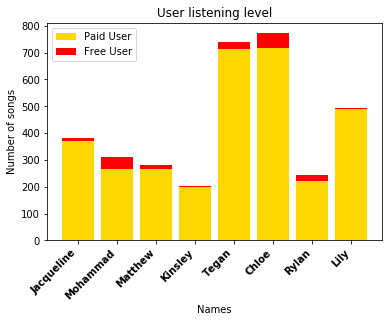

In [22]:
A = np.concatenate( puCount, axis=0 )
B = np.concatenate( fuCount, axis=0 )
names = np.concatenate( first_names, axis=0)
X = np.arange(8)

plt.bar(X, A, label='Paid User', color='gold')
plt.bar(X, B, label='Free User', color = 'r', bottom = A)

# Custom X axis
plt.xticks(X, names, fontweight='bold')
plt.xlabel("Names")
plt.ylabel("Number of songs")
plt.title('User listening level')
plt.legend(loc="upper left")

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.savefig('chart1.png',dpi=100)
plt.show()